# Patronizing and Condescending Language Detection

In [1]:
#dependencies
! pip install nltk
! pip install Unidecode
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from dont_patronize_me import DontPatronizeMe
from wordcloud import WordCloud
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers import Trainer, TrainingArguments
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import os
from collections import Counter


from DPM_preprocessing_over_sampling2_train_test_80_20 import DPM_preprocessing
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# check gpu
# check which gpu we're using
!nvidia-smi
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Sat Feb 19 16:55:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   39C    P0    43W / 120W |      3MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# 1.1 Data analysis of the training data

In [5]:
dpm = DontPatronizeMe('.', '.')

dpm_pp = DPM_preprocessing('.', '.')

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}
(10469, 8)
Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


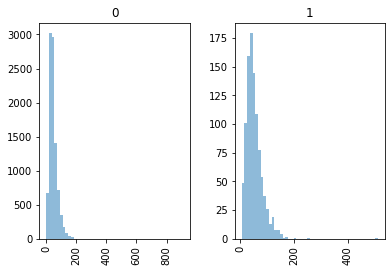

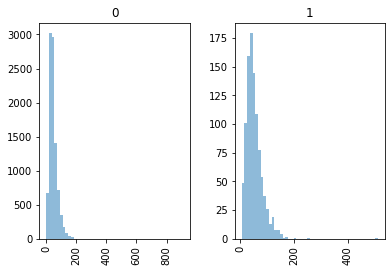

In [6]:
def count_words(sentence):
    return len(sentence.split())
dpm.load_task1()
dpm.load_task2(return_one_hot=True)
df = dpm.train_task1_df
df['lenght'] = df['text'].apply(count_words)
hist = df['lenght'].hist(by=df['label'], bins = 50, alpha = 0.5)
#hist = df['lenght'].hist(by=df['orig_label'], bins = 10, alpha = 0.5)
#hist = df['country'].hist(by=df['label'])
#hist = df['keyword'].hist(by=df['orig_label'])
plt.savefig('histo.jpg', dpi=500)

print(df.shape)
#Preprocessing and over-sampling
dpm_pp.load_task1()
dpm_pp.load_task2(return_one_hot=True)
dpm_pp.load_all_positive()
dpm_pp.load_all_negative()
df_80_pos = dpm_pp._80_positive_df
df_20_pos = dpm_pp._20_positive_df
df_80_neg = dpm_pp._80_negative_df
df_20_neg = dpm_pp._20_negative_df
df['lenght'] = df['text'].apply(count_words)
hist = df['lenght'].hist(by=df['label'], bins = 50, alpha = 0.5)
#hist = df['lenght'].hist(by=df['orig_label'], bins = 10, alpha = 0.5)
#hist = df['country'].hist(by=df['label'])
#hist = df['keyword'].hist(by=df['orig_label'])
plt.savefig('histo.jpg', dpi=500)


In [7]:
print(df_80_pos.shape)
print(df_20_pos.shape)
print(df_80_neg.shape)
print(df_20_neg.shape)
train_df = pd.concat([df_80_pos, df_80_neg])
val_df = pd.concat([df_20_pos, df_20_neg])
total_df = pd.concat([train_df, val_df])
print(train_df.shape)
print(val_df.shape)
print(total_df.shape)

(6621, 7)
(1659, 7)
(6847, 7)
(2629, 7)
(13468, 8)
(4288, 8)
(17756, 8)


In [8]:
def generate_cloud(label,label_type,df):

    if label_type == "label ":
        text = df[df['label'] == label]['text'].values
    else:
        text = df[df['orig_label'] == label]['text'].values
    
    wordcloud = WordCloud().generate(str(text))
    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [9]:
# generate_cloud(0,"label ",dpm.train_task1_df)

In [10]:
# generate_cloud(1,"label ",dpm.train_task1_df)

# 1.2 Qualitative assessment of the dataset

In [11]:
# To be done

# 2 Modelling

## 2.1 Load training, validation and test set

In [12]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [13]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [14]:
train_rows = [] # will contain par_id, label and text
val_rows = []
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label

  train_row = train_df[train_df.par_id==parid]
  for index, row in train_row.iterrows():
    text = train_row.text.values[0]
    label = train_row.label.values[0]
    train_rows.append({
      'par_id':parid,
      'text':text,
      'label':label
    })
#   print(train_row)

  val_row = val_df[val_df.par_id==parid]
  for index, row in val_row.iterrows():
    text = val_row.text.values[0]
    label = val_row.label.values[0]
    val_rows.append({
      'par_id':parid,
      'text':text,
      'label':label
    })
#   print(val_row)

    
trdf1 = pd.DataFrame(train_rows)
valdf1 = pd.DataFrame(val_rows)
# from sklearn.model_selection import train_test_split
# trdf1, valdf1 = train_test_split(trdf1, test_size=0.1)

In [15]:
#over-sampling
print(trdf1.shape)
print(valdf1.shape)

(11614, 3)
(2393, 3)


In [16]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

tedf1 = pd.DataFrame(rows)

In [17]:
# downsample negative instances
# Training
# pcldf = trdf1[trdf1.label==1]
# npos = len(pcldf)
# training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
training_set1 = trdf1
# Validation
# pcldf = valdf1[valdf1.label==1]
# npos = len(pcldf)
# validation_set1 = pd.concat([pcldf,valdf1[valdf1.label==0][:npos*2]])
validation_set1 = valdf1
# Testing
# pcldf = tedf1[tedf1.label==1]
# npos = len(pcldf)
# test_set1 = pd.concat([pcldf,tedf1[tedf1.label==0][:npos*2]])
test_set1 = tedf1
print("Training set length: ",len(training_set1))
print("Validation set length: ",len(validation_set1))
print("Testing set length: ",len(test_set1))
print(training_set1.shape)
training_set1

Training set length:  11614
Validation set length:  2393
Testing set length:  2094
(11614, 3)


,par_id,text,label
0,4341,scheme saw an estimated 150000 children from ...,1
1,4341,scheme saw an estimated 150000 children from ...,1
2,4341,scheme saw an estimated 150000 children from ...,1
3,4341,scheme saw an estimated 150000 children from ...,1
4,4341,scheme saw an estimated 150000 children from ...,1
...,...,...,...
11609,7575,are the poor who live in makeshift structures ...,0
11610,7576,on the other hand the argument has been made t...,0
11611,7577,from ahmed zayed in tripoli libya tripoli caj ...,0
11612,7578,the duo was called by their national football ...,0


In [18]:
class DpmDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = list(input_set['text'])
        self.labels = list(input_set['label'])
        
    def collate_fn(self, batch):

        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
train_dataset = DpmDataset(tokenizer, training_set1)

In [21]:
# Print some example in training set
batch = [sample for sample in train_dataset]

encodings = train_dataset.collate_fn(batch[:10])

for key, value in encodings.items():
  print(f"{key}: {value.numpy().tolist()}")

input_ids: [[101, 5471, 1486, 1126, 3555, 10204, 7629, 1482, 1121, 2869, 2073, 1217, 1850, 1106, 2192, 1104, 1103, 9304, 10721, 1324, 8207, 1206, 3598, 1105, 2424, 1118, 2689, 3791, 1105, 18844, 1150, 1163, 1152, 1156, 1730, 1618, 2491, 102, 0, 0, 0, 0, 0, 0], [101, 5471, 1486, 1126, 3555, 10204, 7629, 1482, 1121, 2869, 2073, 1217, 1850, 1106, 2192, 1104, 1103, 9304, 10721, 1324, 8207, 1206, 3598, 1105, 2424, 1118, 2689, 3791, 1105, 18844, 1150, 1163, 1152, 1156, 1730, 1618, 2491, 102, 0, 0, 0, 0, 0, 0], [101, 5471, 1486, 1126, 3555, 10204, 7629, 1482, 1121, 2869, 2073, 1217, 1850, 1106, 2192, 1104, 1103, 9304, 10721, 1324, 8207, 1206, 3598, 1105, 2424, 1118, 2689, 3791, 1105, 18844, 1150, 1163, 1152, 1156, 1730, 1618, 2491, 102, 0, 0, 0, 0, 0, 0], [101, 5471, 1486, 1126, 3555, 10204, 7629, 1482, 1121, 2869, 2073, 1217, 1850, 1106, 2192, 1104, 1103, 9304, 10721, 1324, 8207, 1206, 3598, 1105, 2424, 1118, 2689, 3791, 1105, 18844, 1150, 1163, 1152, 1156, 1730, 1618, 2491, 102, 0, 0, 0, 0,

## 2.2 Construct Model

In [22]:
class pcl_detection(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        # Task A
        self.projection_a = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                torch.nn.Linear(config.hidden_size, 2))
        
        # Task B
        # TBA
        
        # Task C
        # TBA
        
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
 
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Logits A
        logits_a = self.projection_a(outputs[1])
        
        return logits_a

In [23]:
# Define Loss function
class Trainer_pcl_detection(Trainer):
    def compute_loss(self, model, inputs):
        labels = {}
        labels['label'] = inputs.pop('label')

        outputs = model(**inputs)

        loss_task_a = nn.CrossEntropyLoss()
        labels = labels['label']
        loss = loss_task_a(outputs.view(-1, 2), labels.view(-1))
        
        return loss

## 2.3 Train

In [24]:
def main():
    
    #model = BERT_hate_speech.from_pretrained(model_name)\
    model = pcl_detection.from_pretrained("bert-base-cased")
    #call our custom BERT model and pass as parameter the name of an available pretrained model    
    training_args = TrainingArguments(
        output_dir='./experiment/hate_speech',
        learning_rate = 0.0001,
        logging_steps= 100,
        per_device_train_batch_size=32,
        num_train_epochs = 3,
    )
    trainer = Trainer_pcl_detection(
        model=model,                         
        args=training_args,                 
        train_dataset=train_dataset,                   
        data_collator=train_dataset.collate_fn
    )
    trainer.train()

    trainer.save_model('./models/pcl_bert_finetuned/')



In [ ]:
main()

Some weights of the model checkpoint at bert-base-cased were not used when initializing pcl_detection: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing pcl_detection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing pcl_detection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of pcl_detection were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['projection_a.1.weigh

Step,Training Loss


## 2.4 Evaluation

In [ ]:
def predict_pcl(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  with torch.no_grad():
    for data in tqdm(data_loader): 

      labels = {}
      labels['label'] = data['label']

      tweets = data['text']

      pred = predict_pcl(tweets, tokenizer, model)

      preds.append(np.array(pred['prediction']))
      tot_labels.append(np.array(labels['label']))

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  

  return preds, tot_labels

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/pcl_bert_finetuned/' 
model = pcl_detection.from_pretrained(model_name)

val_dataset = DpmDataset(tokenizer, validation_set1)
# we don't batch our test set unless it's too big
test_loader = DataLoader(val_dataset)
# test_dataset = DpmDataset(tokenizer, tedf1)
# # we don't batch our test set unless it's too big
# test_loader = DataLoader(test_dataset)

preds, tot_labels = evaluate(model, tokenizer, test_loader)
tot_labels = np.array(tot_labels)
preds = np.array(preds)
report = classification_report(tot_labels, preds, target_names=["Not offensive","Offensive"], output_dict= True)
print(report)

print(report['accuracy'])
print(report['Not offensive']['f1-score'])
print(report['Offensive']['f1-score'])

## 2.5 Upload result

In [ ]:
def predict_pcl(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  with torch.no_grad():
    for data in tqdm(data_loader): 

      tweets = data['text']

      pred = predict_pcl(tweets, tokenizer, model)

      preds.append(pred['prediction'].item())

  return preds

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/pcl_bert_finetuned/' 
model = pcl_detection.from_pretrained(model_name)

test_dataset = DpmDataset(tokenizer, tedf1)
# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)
# val_dataset = DpmDataset(tokenizer, validation_set1)
# # we don't batch our test set unless it's too big
# test_loader = DataLoader(val_dataset)


preds = evaluate(model, tokenizer, test_loader)

In [ ]:
preds = np.array(preds)

In [ ]:
preds_1 = preds_1.reshape(-1)

In [ ]:
Counter(preds_1)

In [ ]:
labels2file([[k] for k in preds], 'task1.txt')